**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Titanic

In [2]:
df = pd.read_csv("./titanic_data/train.csv")

In [3]:
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
target = 'Survived'

# padrão 20% para teste
df_train, df_test = train_test_split(df,
                                     test_size = 0.2,
                                     random_state=75)

print("df.shape:      ",df.shape)
print("df_train.shape:",df_train.shape)
print("df_test.shape: ",df_test.shape)


X_train = df_train.drop(target, axis=1) # drop labels for training set
y_train = df_train[target].copy()

X_test = df_test.drop(target, axis=1) # drop labels for training set
y_test = df_test[target].copy()

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

df.shape:       (891, 12)
df_train.shape: (712, 12)
df_test.shape:  (179, 12)
X_train.shape: (712, 11)
y_train.shape: (712,)


# Teste HistGradientBoostingClassifier and HalvingRandomSearchCV

In [6]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
871,872,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
279,280,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S
659,660,1,"Newell, Mr. Arthur Webster",male,58.0,0,2,35273,113.2750,D48,C
650,651,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
351,352,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S


In [8]:
# numeric_transformer
numeric_features = X_train.select_dtypes(include='number').columns # all numericals
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical transformer
categorical_features = X_train.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
        # MUITA Atenção aos argumentos do ColumnTransformer:
        remainder='passthrough',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None,
        verbose=False)

# GridSearch | RandomizedSearchCV
param_grid = [{"learning_rate" : [1] # Use 1 for no shrinkage.
               }, 
             ]
classifier = GradientBoostingClassifier() # HistGradientBoostingClassifier()

grid_search = GridSearchCV( #HalvingRandomSearchCV(
                            classifier,
                            param_grid = param_grid, #param_distributions=param_grid,
                            cv=5,
                            verbose=False,
                            refit=True)

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', preprocessor),
    ('grid_search', grid_search)
])

In [9]:
prepare_select_and_predict_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                              

# cross_val_predict

In [10]:
from sklearn.model_selection import cross_val_predict

y_scores     = cross_val_predict(prepare_select_and_predict_pipeline, X_train, y_train, cv=5, method='predict_proba')
y_train_pred = cross_val_predict(prepare_select_and_predict_pipeline, X_train, y_train, cv=5, method='predict')

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[386,  44],
       [ 85, 197]])

# Precision Recall Curve

In [12]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

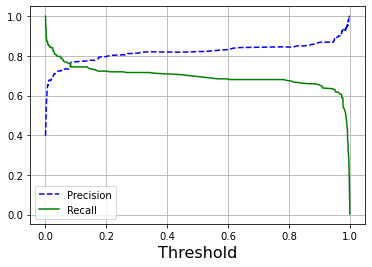

In [13]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

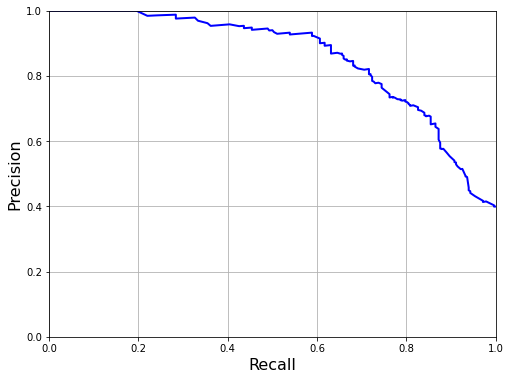

In [14]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC_AUC

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores[:,1])

0.8663450437077354

## Tresholds

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:,1])

# Best treshold

In [19]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

y_train_pred_treshold = np.where(y_scores[:,1] >= optimal_threshold,1,0)

0.34140878268230485


In [31]:
tpr_opt = tpr[np.argmax(thresholds <= optimal_threshold)]
fpr_opt = fpr[np.argmax(thresholds <= optimal_threshold)]

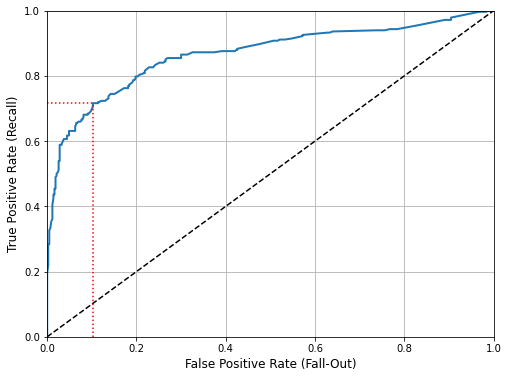

In [33]:
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([fpr_opt, fpr_opt], [0., tpr_opt], "r:")   # Not shown
plt.plot([0., fpr_opt], [tpr_opt, tpr_opt], "r:")   # Not shown

plt.show()

### Comparando diferentes tresholds

In [25]:
confusion_matrix(y_train, y_train_pred)

array([[386,  44],
       [ 85, 197]])

In [26]:
confusion_matrix(y_train, y_train_pred_treshold)

array([[386,  44],
       [ 80, 202]])